In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Adding countries to the dataframe

In [0]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/JedhaBootcamp/FULL_STACK_12_WEEK_PROGRAM/master/S0.4%20--%20R%C3%A9duction%20de%20Dimensions%20%26%20Boosting/Projet%20--%20FRAUDULENT%20ACTIVITIES/Datasets/Fraud_Data.csv?token=AA5YCUZZ2SHWDYMOAYHCAEC6HLEU2")
dfip = pd.read_csv("https://raw.githubusercontent.com/JedhaBootcamp/FULL_STACK_12_WEEK_PROGRAM/master/S0.4%20--%20R%C3%A9duction%20de%20Dimensions%20%26%20Boosting/Projet%20--%20FRAUDULENT%20ACTIVITIES/Datasets/IpAddress_to_Country.csv?token=AA5YCU7YZASOBZABIZ7JJRS6HLEUU")
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


##Checking for null values

In [0]:
df.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

##A really clever function

In [0]:
def transform_ip(arg) :
    try :
        return dfip.country[(dfip.lower_bound_ip_address <= arg) & (dfip.upper_bound_ip_address >= arg)].iloc[0]
    except IndexError :
        return "Unknown country"  

df["country"] = df.ip_address.apply(transform_ip)

In [0]:
fraud_data = df.to_csv('fraud_data.csv')
uploaded = drive.CreateFile({'title': 'fraud_data.csv'})
uploaded.SetContentFile('fraud_data.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1n49rzVAegC16TvobTAsUK9UtajnZD68n


In [0]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


#Data exploration

In [0]:
downloaded = drive.CreateFile({'id':uploaded.get('id')})
downloaded.GetContentFile('fraud_data.csv')

df = pd.read_csv('fraud_data.csv',index_col=0)
df_fraudulent = df[df["class"]==1]
df_notfraudulent = df[df["class"]==0]
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [0]:
df_fraudulent.describe()

,user_id,purchase_value,age,ip_address,class
count,14151.000000,14151.000000,14151.000000,1.415100e+04,14151.0
mean,200869.065366,36.993004,33.318281,2.131918e+09,1.0
std,116615.028662,18.397654,8.568001,1.224590e+09,0.0
min,39.000000,9.000000,18.000000,2.278096e+06,1.0
25%,98314.000000,22.000000,27.000000,1.107616e+09,1.0
50%,200526.000000,35.000000,33.000000,2.141692e+09,1.0
75%,303018.000000,49.000000,39.000000,3.184225e+09,1.0
max,400000.000000,111.000000,68.000000,4.294131e+09,1.0


In [0]:
df_notfraudulent.describe()

,user_id,purchase_value,age,ip_address,class
count,136961.000000,136961.000000,136961.000000,1.369610e+05,136961.0
mean,200098.920123,36.929418,33.122356,2.154235e+09,0.0
std,115239.994370,18.315064,8.622678,1.250927e+09,0.0
min,2.000000,9.000000,18.000000,5.209350e+04,0.0
25%,100789.000000,22.000000,27.000000,1.084381e+09,0.0
50%,199909.000000,35.000000,33.000000,2.155916e+09,0.0
75%,299724.000000,49.000000,39.000000,3.249408e+09,0.0
max,399997.000000,154.000000,76.000000,4.294850e+09,0.0


In [0]:
devicegroup = df.groupby("device_id").mean()
devicegroup["device_id"] = devicegroup.index
devicegroup = devicegroup.reset_index(drop=True)
devicegroup.sort_values(by="class", ascending=False)

,user_id,purchase_value,age,ip_address,class,device_id
35389,60126.0,19.0,28.0,2.764869e+09,1.0,GRZJSVOZZGVCJ
16481,145555.0,67.0,37.0,2.250499e+09,1.0,DCRMMDOIBYDMR
91148,272322.5,43.5,32.5,1.366578e+09,1.0,RFBQCXGNPFCAS
32182,369638.0,48.0,27.0,1.909780e+09,1.0,GBZNVCDXTKKXF
49304,264118.0,80.0,34.0,2.078159e+09,1.0,JIREGYLRRFTKU
...,...,...,...,...,...,...
47156,176763.0,37.0,58.0,4.501174e+08,0.0,IYNDPXPSVESAO
47155,174304.0,61.0,25.0,2.907354e+09,0.0,IYNCVVXLMSAED
47154,260859.0,35.0,31.0,2.370404e+09,0.0,IYMNSSFJRZBDR
47153,90680.0,31.0,28.0,1.655478e+09,0.0,IYLZGOHLYMTXV


In [0]:
devicegroup["devicegroup"]=devicegroup["class"].apply(lambda X: 1 if X<=0.2 else 2 if 0.2<X<=0.4 else 3 if 0.4<X<=0.6 else 4 if 0.6<X<=0.8 else 5)
devicegroup.head()

,user_id,purchase_value,age,ip_address,class,device_id,devicegroup
0,226648.000000,45.0,34.0,2.494581e+09,0.000000,AAALBGNHHVMKG,1
1,103319.000000,94.0,29.0,8.092637e+08,0.000000,AAAWIHVCQELTP,1
2,36633.000000,46.0,40.0,2.891497e+06,0.000000,AAAXJHWCLISKY,1
3,222337.818182,57.0,36.0,1.377849e+09,0.909091,AAAXXOZJRZRAO,5
4,344305.000000,10.0,25.0,3.960443e+09,0.000000,AABFGRPBQHWFQ,1


In [0]:
usergr = df.groupby("user_id").sum()
usergr.sort_values(by="class", ascending=False)

,purchase_value,age,ip_address,class
user_id,,,,
199959,23,41,1.063537e+09,1
158562,42,23,3.362789e+09,1
158955,41,34,4.253075e+09,1
158943,15,26,1.223450e+09,1
158931,57,37,2.899879e+09,1
...,...,...,...,...
157036,44,41,2.479632e+09,0
157035,23,36,3.549111e+09,0
23078,35,31,1.834619e+09,0


##Sum visualization

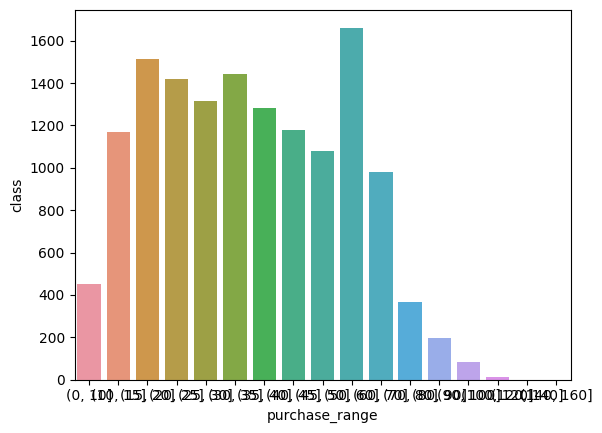

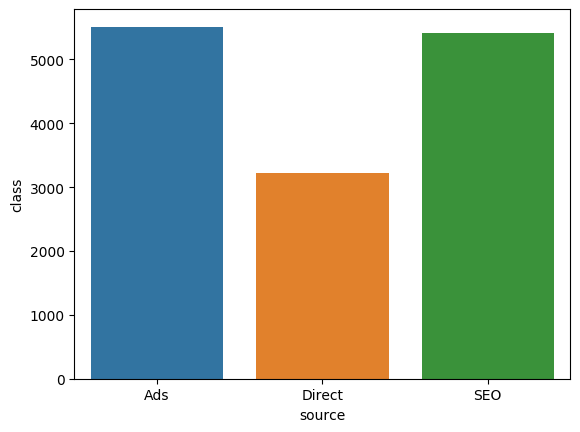

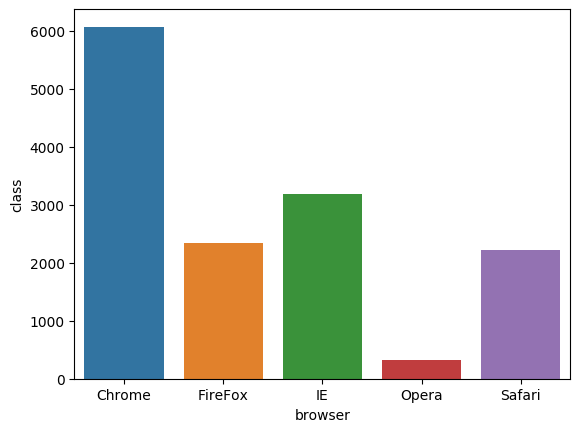

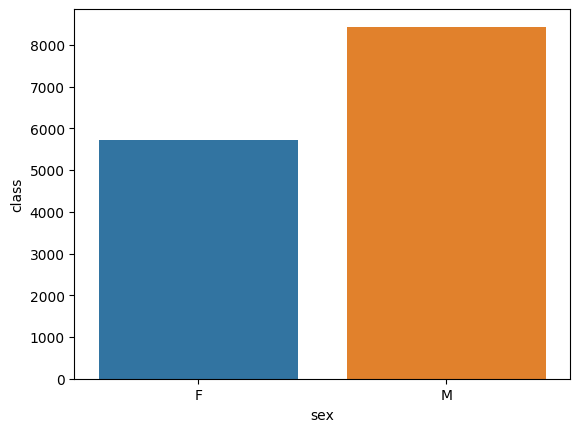

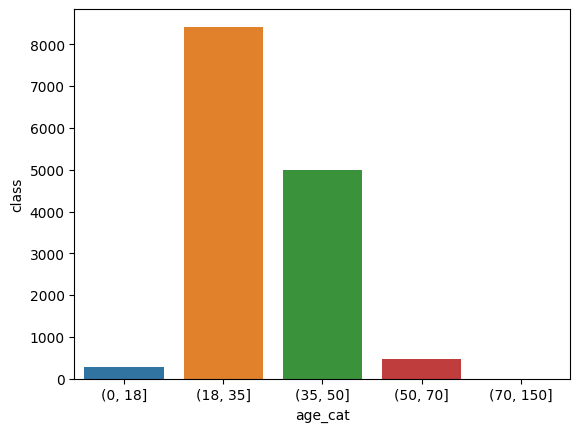

In [0]:
df["age_cat"]=pd.cut(x=df['age'], bins=[0, 18, 35, 50, 70, 150])
df["purchase_range"]=pd.cut(x=df['purchase_value'], bins=[0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 140, 160])

columns = ["purchase_range","source","browser","sex","age_cat"]

for column in columns:
  dfplot = df.groupby(column).sum()
  sns.barplot(x=dfplot.index,y=dfplot["class"])
  plt.show()

##Mean visualization

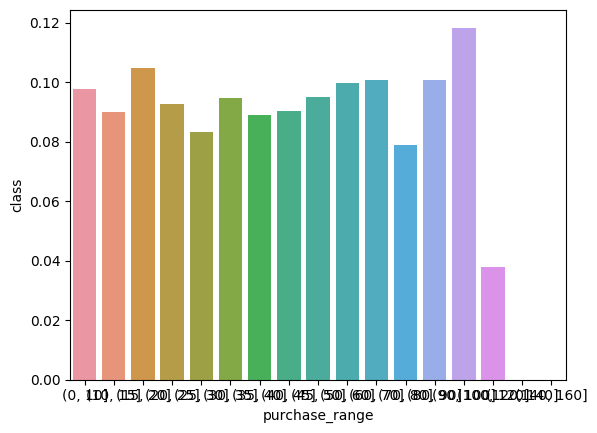

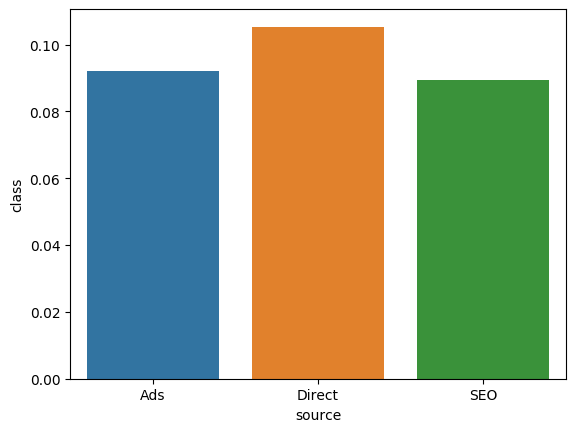

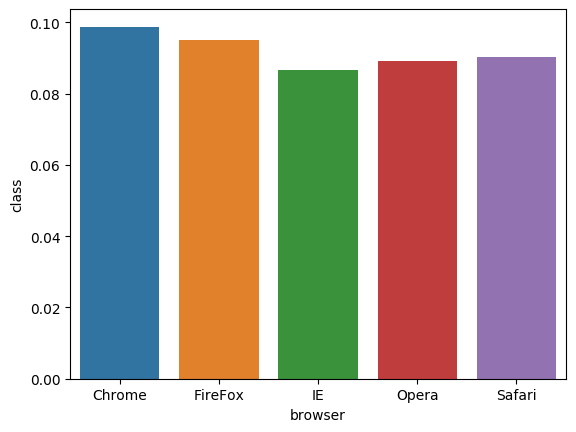

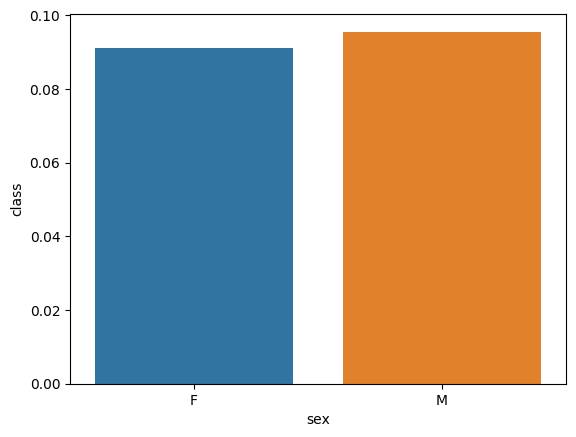

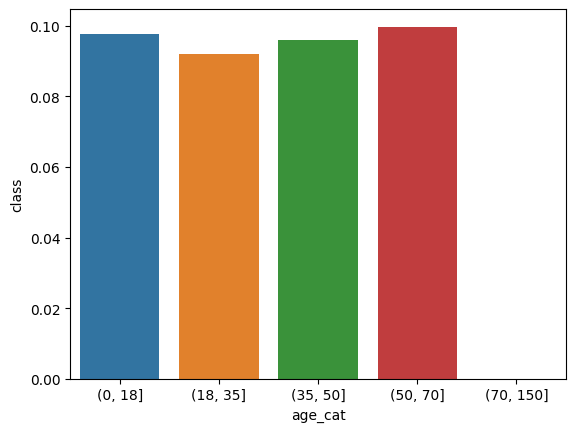

In [0]:
df["age_cat"]=pd.cut(x=df['age'], bins=[0, 18, 35, 50, 70, 150])
df["purchase_range"]=pd.cut(x=df['purchase_value'], bins=[0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 140, 160])

columns = ["purchase_range","source","browser","sex","age_cat"]

for column in columns:
  dfplot = df.groupby(column).mean()
  sns.barplot(x=dfplot.index,y=dfplot["class"])
  plt.show()

##Country exploration

In [0]:
pd.options.display.max_rows = 200
countrymean = df.groupby("country").mean()
countrymean = countrymean[countrymean["class"] != 0]
countrymean = countrymean.drop(["user_id", "purchase_value", "age", "ip_address"], axis=1)
countrymean.sort_values(by="class", ascending=False)

,class
country,
Turkmenistan,1.000000
Namibia,0.434783
Sri Lanka,0.419355
Luxembourg,0.388889
Virgin Islands (U.S.),0.333333
Ecuador,0.264151
Tunisia,0.262712
Peru,0.260504
Bolivia,0.245283


In [0]:
countrysum = df.groupby("country").sum()
countrysum = countrysum[countrysum["class"] != 0]
countrysum = countrysum.drop(["user_id", "purchase_value", "age", "ip_address"], axis=1)
countrysum.sort_values(by="class", ascending=False)

,class
country,
United States,5551
Unknown country,1883
China,1043
Japan,715
United Kingdom,477
Korea Republic of,380
Canada,348
France,300
Brazil,270


##Purchase times

In [0]:
import datetime
from datetime import timedelta
today = datetime.datetime.today()
from dateutil import parser

df["purchase_hour"] = df.purchase_time.apply(lambda X : parser.parse(X).hour)
df["purchase_month"] = df.purchase_time.apply(lambda X : parser.parse(X).month)
df["purchase_day"] = df.purchase_time.apply(lambda X : parser.parse(X).day)
df["purchase_weekday"] = df.purchase_time.apply(lambda X : parser.parse(X).weekday())
df["timedelta"] = df.apply(lambda X : (parser.parse(X["purchase_time"]) - parser.parse(X["signup_time"])).total_seconds(),axis=1) #Thanks R.

In [0]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,age_cat,purchase_range,purchase_hour,purchase_month,purchase_day,purchase_weekday,timedelta
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,"(35, 50]","(30, 35]",2,4,18,5,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,"(50, 70]","(15, 20]",1,6,8,0,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,"(50, 70]","(10, 15]",18,1,1,3,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country,"(35, 50]","(40, 45]",13,5,4,0,492085.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,"(35, 50]","(35, 40]",18,9,9,2,4361461.0


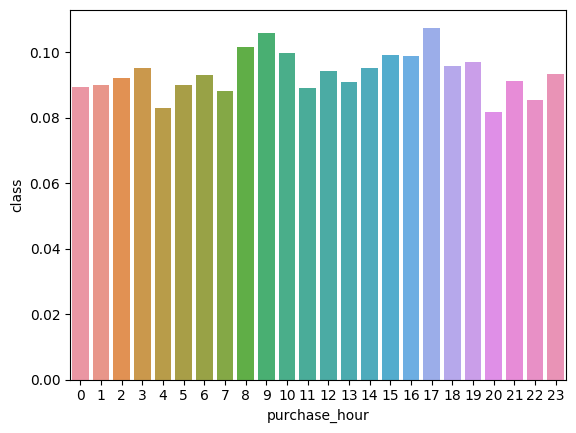

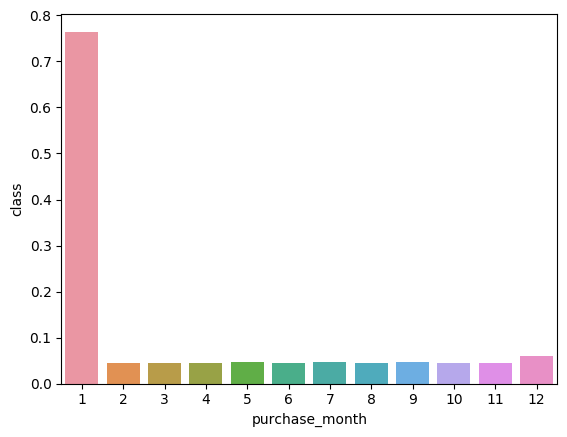

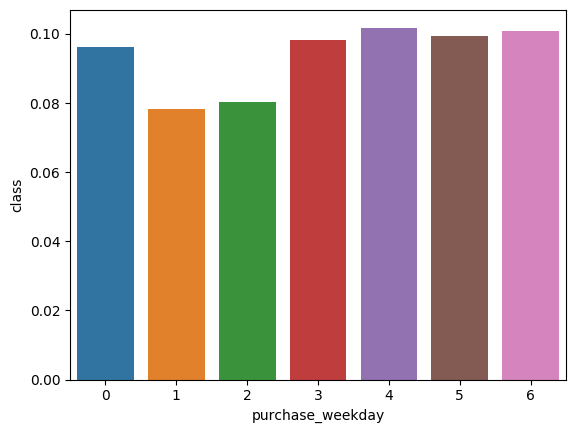

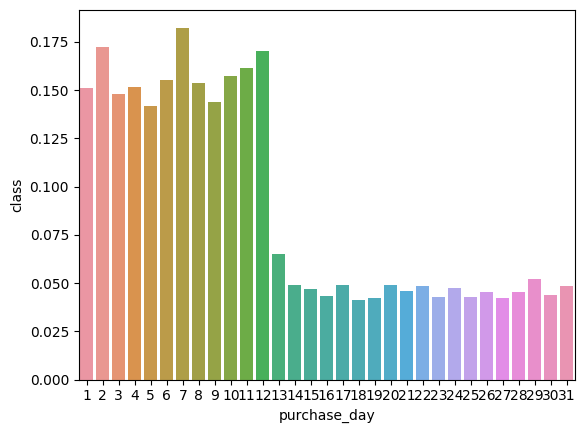

In [0]:
columns = ["purchase_hour","purchase_month","purchase_weekday","purchase_day"]

for column in columns:
  dfplot = df.groupby(column).mean()
  sns.barplot(x=dfplot.index,y=dfplot["class"])
  plt.show()

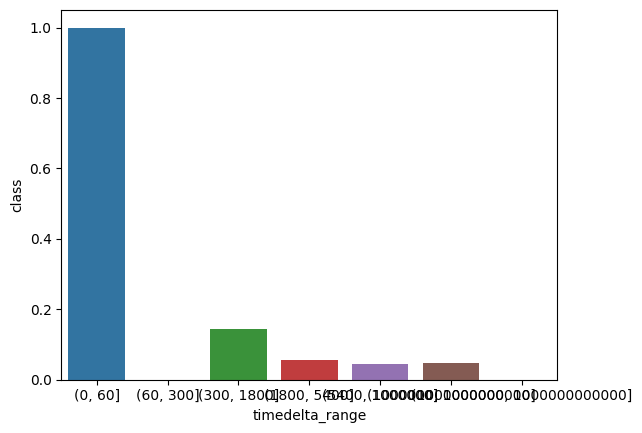

In [0]:
df["timedelta_range"]=pd.cut(x=df['timedelta'], bins=[0, 60, 300, 1800, 5400, 10**6, 10**9,10**12])

dfplot = df.groupby("timedelta_range").mean()

sns.barplot(x=dfplot.index,y=dfplot["class"])
plt.show()

#Classification

In [0]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn import svm
from sklearn.metrics import make_scorer

In [0]:
downloaded = drive.CreateFile({'id':uploaded.get('id')})
downloaded.GetContentFile('fraud_data.csv')  

df = pd.read_csv('fraud_data.csv',index_col=0)
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [0]:
df_fraudulent = df[df["class"]==1]
df_notfraudulent = df[df["class"]==0]

df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [0]:
print(df["class"].sum())
print(len(df))
print(df["class"].sum()/len(df))

14151
151112
0.09364577267192546


##Feature engineering

In [0]:
df["purchase_hour"] = df.purchase_time.apply(lambda X : parser.parse(X).hour)
df["purchase_month"] = df.purchase_time.apply(lambda X : parser.parse(X).month)
df["purchase_day"] = df.purchase_time.apply(lambda X : parser.parse(X).day)
df["purchase_weekday"] = df.purchase_time.apply(lambda X : parser.parse(X).weekday())
df["timedelta"] = df.apply(lambda X : (parser.parse(X["purchase_time"]) - parser.parse(X["signup_time"])).total_seconds(),axis=1) #Thanks R.
df = pd.merge(right=devicegroup[["devicegroup","device_id"]], left=df, left_on = "device_id", right_on = "device_id")
df = df.drop(["user_id", "device_id", "signup_time", "purchase_time", "ip_address"], axis=1)
df.head()

,purchase_value,source,browser,sex,age,class,country,purchase_hour,purchase_month,purchase_day,purchase_weekday,timedelta,devicegroup
0,34,SEO,Chrome,M,39,0,Japan,2,4,18,5,4506682.0,1
1,16,Ads,Chrome,F,53,0,United States,1,6,8,0,17944.0,1
2,15,SEO,Opera,M,53,1,United States,18,1,1,3,1.0,5
3,15,SEO,Opera,M,53,1,United States,18,1,1,3,1.0,5
4,15,SEO,Opera,M,53,1,United States,18,1,1,3,1.0,5


In [0]:
df=pd.get_dummies(df, columns = ["country","source","sex","browser","devicegroup","purchase_hour","purchase_month","purchase_day","purchase_weekday"], drop_first=True)
df.head()

,purchase_value,age,class,timedelta,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bermuda,country_Bhutan,country_Bolivia,country_Bonaire; Sint Eustatius; Saba,country_Bosnia and Herzegowina,country_Botswana,country_Brazil,country_British Indian Ocean Territory,country_Brunei Darussalam,country_Bulgaria,country_Burkina Faso,country_Burundi,country_Cambodia,country_Cameroon,country_Canada,country_Cape Verde,country_Cayman Islands,country_Chile,country_China,...,purchase_month_9,purchase_month_10,purchase_month_11,purchase_month_12,purchase_day_2,purchase_day_3,purchase_day_4,purchase_day_5,purchase_day_6,purchase_day_7,purchase_day_8,purchase_day_9,purchase_day_10,purchase_day_11,purchase_day_12,purchase_day_13,purchase_day_14,purchase_day_15,purchase_day_16,purchase_day_17,purchase_day_18,purchase_day_19,purchase_day_20,purchase_day_21,purchase_day_22,purchase_day_23,purchase_day_24,purchase_day_25,purchase_day_26,purchase_day_27,purchase_day_28,purchase_day_29,purchase_day_30,purchase_day_31,purchase_weekday_1,purchase_weekday_2,purchase_weekday_3,purchase_weekday_4,purchase_weekday_5,purchase_weekday_6
0,34,39,0,4506682.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,16,53,0,17944.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,15,53,1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,15,53,1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,15,53,1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


##Classifiers without resampling

In [0]:
y = df["class"]
X = df.drop("class", 1)

num_col = ["purchase_value","age","timedelta"]
cat_col = X.drop(["purchase_value","age","timedelta"],axis=1).columns

X_num = X[num_col]
X_cat = X[cat_col]

X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_num, X_cat, y, test_size =0.2)

sc_x = StandardScaler()
X_train_num_norm = pd.DataFrame(sc_x.fit_transform(X_train_num),columns=X_train_num.columns, index = X_train_num.index)
X_test_num_norm = pd.DataFrame(sc_x.transform(X_test_num),columns=X_test_num.columns, index = X_test_num.index)

X_train = pd.merge(X_train_num_norm, X_train_cat,left_index=True, right_index=True)
X_test = pd.merge(X_test_num_norm, X_test_cat,left_index=True, right_index=True)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) :
Accuracy: 0.98 (+/- 0.00)


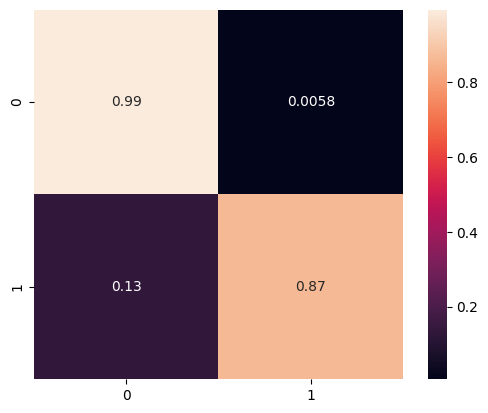

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) :
Accuracy: 0.98 (+/- 0.00)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


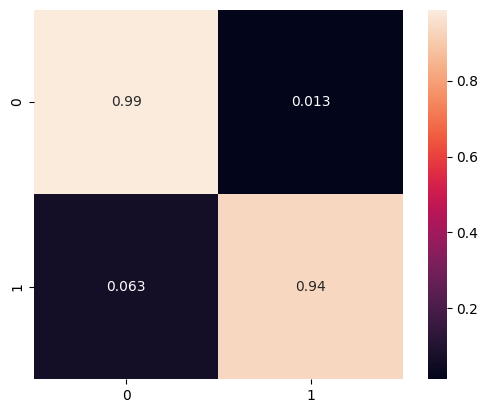

In [0]:
models = (
    BernoulliNB(),
    LogisticRegression()  
)

for m in models :
      cv = cross_val_score(m, X_train, y_train, cv=10)
      print(m, ":")
      print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))
      m.fit(X_train, y_train)
      pred = m.predict(X_test)
      cm = confusion_matrix(y_test, pred, normalize="true")
      sns.heatmap(cm, annot=True, square=True)
      plt.show()

##Classifiers after undersampling

In [0]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_rdmsamp, y_rdmsamp = rus.fit_resample(X, y)

X_rdmsamp = pd.DataFrame(X_rdmsamp, columns = X.columns)

X_num = X_rdmsamp[num_col]
X_cat = X_rdmsamp[cat_col]

X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_num, X_cat, y_rdmsamp, test_size = 0.2)

sc_x = StandardScaler()
X_train_num_norm = pd.DataFrame(sc_x.fit_transform(X_train_num),columns=X_train_num.columns, index = X_train_num.index)
X_test_num_norm = pd.DataFrame(sc_x.transform(X_test_num),columns=X_test_num.columns, index = X_test_num.index)

X_train = pd.merge(X_train_num_norm, X_train_cat,left_index=True, right_index=True)
X_test = pd.merge(X_test_num_norm, X_test_cat,left_index=True, right_index=True)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) :
Accuracy: 0.95 (+/- 0.01)


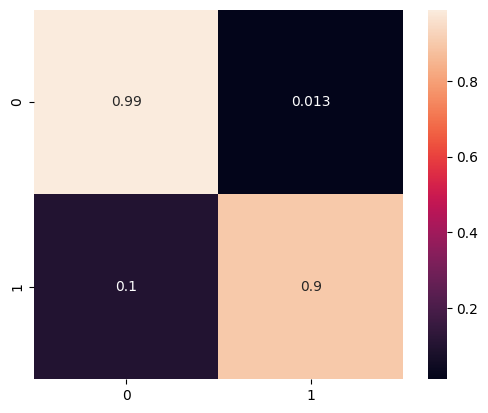

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) :
Accuracy: 0.99 (+/- 0.00)


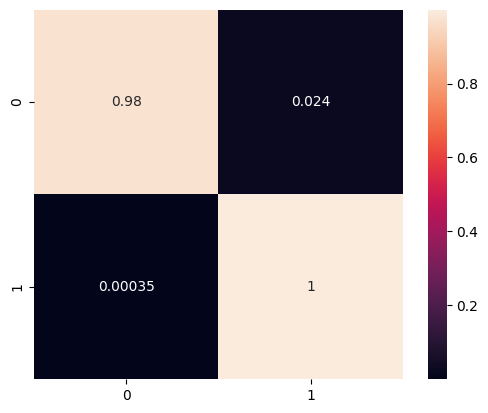

In [0]:
models = (
    BernoulliNB(),
    LogisticRegression()  
)

for m in models :
      cv = cross_val_score(m, X_train, y_train, cv=10)
      print(m, ":")
      print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))
      m.fit(X_train, y_train)
      pred = m.predict(X_test)
      cm = confusion_matrix(y_test, pred, normalize="true")
      sns.heatmap(cm, annot=True, square=True)
      plt.show()

Tuning hyper-parameters for precision

{'n_estimators': 500} :
Accuracy: 0.99 (+/- 0.00)


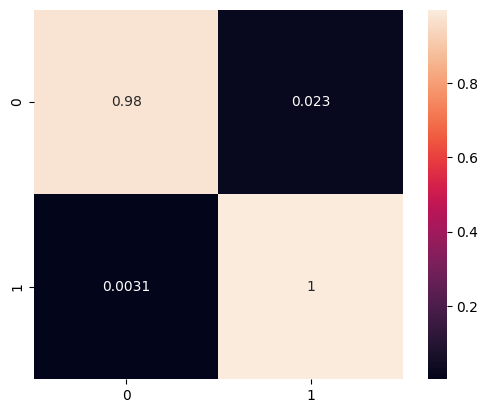

Tuning hyper-parameters for recall

{'n_estimators': 100} :
Accuracy: 0.99 (+/- 0.00)


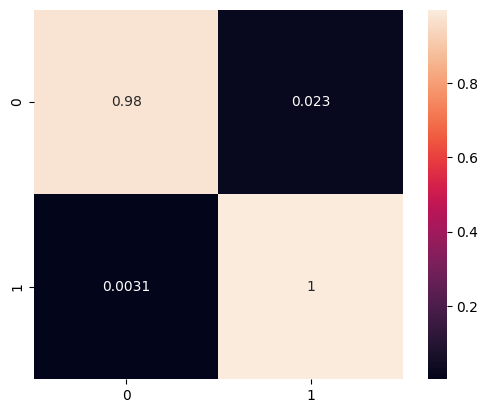

In [0]:
m = RandomForestClassifier()
param_grid = {'n_estimators': [100,200,500,1000]}
scores = ['precision', 'recall']

for score in scores:
    print("Tuning hyper-parameters for %s" % score)
    print()
    grid = GridSearchCV(m, param_grid, scoring='%s_macro' % score)
    grid.fit(X_train,y_train)
    print(grid.best_params_, ":")
    mean = max(grid.cv_results_['mean_test_score'])
    std = grid.cv_results_['std_test_score'][grid.cv_results_['mean_test_score'].tolist().index(max(grid.cv_results_['mean_test_score']))]
    print("Accuracy: %0.2f (+/- %0.2f)" % (mean, std * 2))
    pred = grid.predict(X_test)
    cm = confusion_matrix(y_test, pred, normalize="true")
    sns.heatmap(cm, annot=True, square=True)
    plt.show()

Tuning hyper-parameters for precision

{'learning_rate': 0.1, 'n_estimators': 500} :
Accuracy: 0.99 (+/- 0.00)


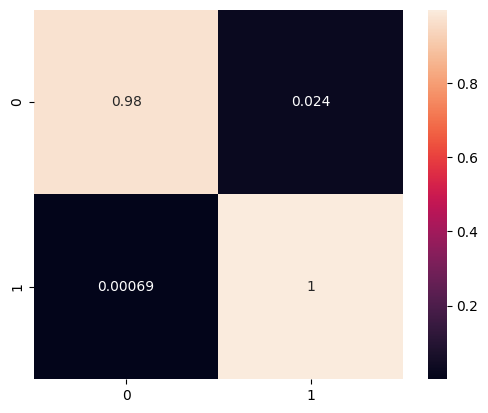

Tuning hyper-parameters for recall

{'learning_rate': 0.1, 'n_estimators': 500} :
Accuracy: 0.99 (+/- 0.00)


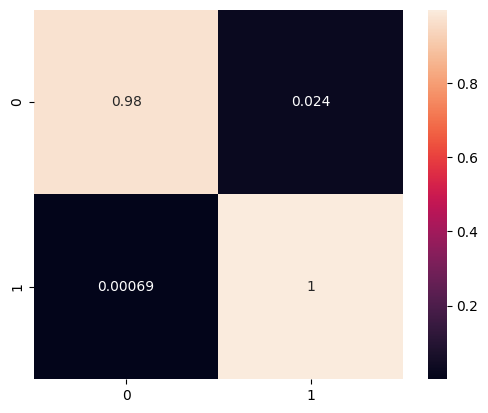

Tuning hyper-parameters for precision

{'learning_rate': 0.05, 'n_estimators': 100} :
Accuracy: 0.99 (+/- 0.00)


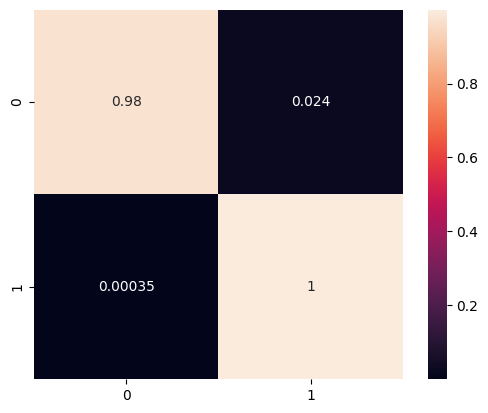

Tuning hyper-parameters for recall

{'learning_rate': 0.05, 'n_estimators': 250} :
Accuracy: 0.99 (+/- 0.00)


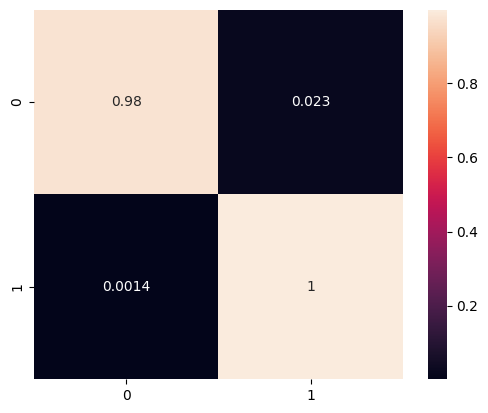

In [0]:
models = [AdaBoostClassifier(), GradientBoostingClassifier()]
param_grid = {'n_estimators' : [100,250,500], 'learning_rate' : [0.1,0.05,0.01]}
scores = ['precision', 'recall']

for m in models:
    for score in scores:
        print("Tuning hyper-parameters for %s" % score)
        print()
        grid = GridSearchCV(m, param_grid, scoring='%s_macro' % score)
        grid.fit(X_train,y_train)
        print(grid.best_params_, ":")
        mean = max(grid.cv_results_['mean_test_score'])
        std = grid.cv_results_['std_test_score'][grid.cv_results_['mean_test_score'].tolist().index(max(grid.cv_results_['mean_test_score']))]
        print("Accuracy: %0.2f (+/- %0.2f)" % (mean, std * 2))
        pred = grid.predict(X_test)
        cm = confusion_matrix(y_test, pred, normalize="true")
        sns.heatmap(cm, annot=True, square=True)
        plt.show()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) :
Accuracy: 0.99 (+/- 0.00)


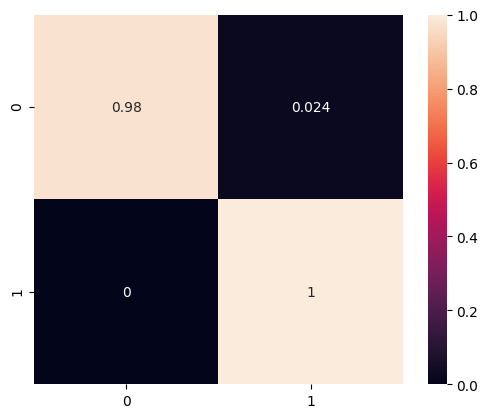

In [0]:
m = XGBClassifier()

cv = cross_val_score(m, X_train, y_train, cv=10)
print(m, ":")
print("Accuracy: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))
m.fit(X_train, y_train)
pred = m.predict(X_test)
cm = confusion_matrix(y_test, pred, normalize="true")
sns.heatmap(cm, annot=True, square=True)
plt.show()

In [0]:
m = svm.SVC()
param_grid = [{'base_estimator__kernel': ['rbf'], 'base_estimator__gamma': [1e-3, 1e-4], 'base_estimator__C': [1, 10, 100, 1000]}, {'base_estimator__kernel': ['linear'], 'base_estimator__C': [1, 10, 100, 1000]}] 
scores = ['precision', 'recall']

for score in scores:
    print("Tuning hyper-parameters for %s" % score)
    print()
    grid = GridSearchCV(BaggingClassifier(m), param_grid, scoring='%s_macro' % score)
    grid.fit(X_train,y_train)
    print(grid.best_params_, ":")
    mean = max(grid.cv_results_['mean_test_score'])
    std = grid.cv_results_['std_test_score'][grid.cv_results_['mean_test_score'].tolist().index(max(grid.cv_results_['mean_test_score']))]
    print("Accuracy: %0.2f (+/- %0.2f)" % (mean, std * 2))
    pred = grid.predict(X_test)
    cm = confusion_matrix(y_test, pred, normalize="true")
    sns.heatmap(cm, annot=True, square=True)
    plt.show()

Tuning hyper-parameters for precision

